In [1]:
# Élodie Millan
# June 2020
# Langevin equation 3D for a free particule close to a rigid wall without inertia and with weight.

import numpy as np

# from OverdampedLangevin3D import Langevin3D
from InertialLangevin3D import InertialLangevin3D


class RigidWallOverdampedLangevin3D(InertialLangevin3D):  # , Langevin3D
    def __init__(self, dt, Nt, R, rho, rhoF=1000.0, eta=0.001, T=300.0, x0=None, alpha = 1):
        """

        :param dt: float - Time step [s].
        :param Nt: int - Number of time points.
        :param R: float - Radius of particule [m].
        :param rho: float - Volumic mass of the particule [kg/m³].
        :param rhoF: float - Volumic mass of the fluid [kg/m³] (DEFAULT = 1000 [kg/m³]).
        :param eta: float - Fluid viscosity (DEFAULT = 0.001 [Pa/s]).
        :param T: float - Temperature (DEFAULT = 300 [k]).
        :param x0: array float - Initial position of particule (DEFAULT = (0,0,R) [m]).
        """
        if x0 == None:
            x0 = (0.0, 0.0, R)
        super().__init__(dt, Nt, R, rho, eta=eta, T=T, x0=x0)
        self.rhoF = rhoF
        self.lD = 50e-9  # Debay length
        self.g = 9.81  # m/s²
        self.m = rho * (4 / 3) * np.pi * R ** 3
        self.delta_m = (4 / 3) * np.pi * self.R ** 3 * (self.rho - self.rhoF)
        self.lB = (self.kb * self.T) / (self.delta_m * self.g)  # Boltzmann length
        self.alpha = alpha

    def _gamma_xy(self, zi_1):
        """
        Intern methode of RigidWallInertialLangevin3D class - gamma on x and y at time t-dt.

        :param zi_1: float - Perpendicular position by the wall z at (t - dt).

        :return: gamma_x = gamma_y = 6πη(z)R : the gamma value for x and y trajectories dependant of z(t-dt).
        """
        # Libchaber formula
        self.gamma_xy = (
            6
            * np.pi
            * self.R
            * self.eta
            * (
                1
                - ((9 * self.R) / (16 * (zi_1 + self.R)))
                + (self.R / (8 * (zi_1 + self.R))) ** 3
                - (45 * self.R / (256 * (zi_1 + self.R))) ** 4
                - (self.R / (16 * (zi_1 + self.R))) ** 5
            )
            ** (-1)
        )
        # print("gamma_xy = ", self.gamma_xy)
        return self.gamma_xy

    def _gamma_z(self, zi_1):
        """
        Intern methode of RigidWallInertialLangevin3D class - gamma on z at time t-dt.

        :param zi_1: float - Perpendicular position by the wall z at (t - dt).

        :return: float - gamma_z = 6πη(z)R : the gamma value for z trajectory dependant of z(t-dt).
        """
        # Padé formula
        self.gamma_z = (
            6
            * np.pi
            * self.R
            * self.eta
            * (
                (
                    (6 * zi_1 ** 2 + 2 * self.R * zi_1)
                    / (6 * zi_1 ** 2 + 9 * self.R * zi_1 + 2 * self.R ** 2)
                )
                ** (-1)
            )
        )

        # print("gamma_z = ", self.gamma_z)
        return self.gamma_z

    def _a(self, gamma):
        """
        Intern methode of RigidWallInertialLangevin3D class - white noise a = sqrt(k T gamma) at t-dt.

        :param gamma: the gamma value used (depends of the coordinate used).

        :return: The white noise a at the position z(t-dt) for a gamma value on x/y or z.
        """

        a = np.sqrt(2 * self.kb * self.T / gamma)

        return a

    def _PositionXi(self, xi_1, zi_1, rng, axis=None):
        """
        Intern methode of InertialLangevin3D class - Position of a Brownian particule inertial with rigid wall, at time t.

        :param xi_1: float - Position of the particule at (t - dt).
        :param zi_1: float - Perpendicular position by the wall z at (t - dt).
        :param rng: a random number for dBt/dt white noise.
        :param axis: The axis used : put "z" if z axis or None if x/y axis.

        :return: The position of the particule at time t.
        """

        if axis == "z":
            gamma = self._gamma_z(zi_1)
            weight = self.delta_m * self.g * self.dt / (gamma)
            elec = (
                (4 * self.kb * self.T)
                / (self.lD)
                * np.exp(-zi_1 / self.lD)
                * self.dt
                / gamma
            )
            correction = self.alpha * (
               self.kb
               * self.T
               * (42 * self.R * zi_1 ** 2 + 24 * self.R ** 2 * zi_1 + 4 * self.R ** 3)
               / ( (6 * zi_1 ** 2 + 9 * self.R * zi_1 + 2 * self.R ** 2) * (6*zi_1**2 + 2*self.R*zi_1) )
               * self.dt
               / gamma
            )

        else:
            gamma = self._gamma_xy(zi_1)
            elec = 0
            weight = 0
            correction = 0

        xi = xi_1 - weight + elec + correction + self._a(gamma) * rng * self.dt

        if axis == "z":
            if xi <= 0:
                xi = -xi

        return xi

    def trajectory(self, output=False):
        """

        :param output: Boolean, if true function output x, y, z (default : false).

        :return: return the x, y, z trajectory.
        """
        rngx = (1 / np.sqrt(self.dt)) * np.random.default_rng().normal(
            0.0, 1, size=self.Nt
        )
        rngy = (1 / np.sqrt(self.dt)) * np.random.default_rng().normal(
            0.0, 1, size=self.Nt
        )
        rngz = (1 / np.sqrt(self.dt)) * np.random.default_rng().normal(
            0.0, 1, size=self.Nt
        )

        self.rngx = rngx
        self.rngy = rngy
        self.rngz = rngz

        x = np.zeros(self.Nt)
        y = np.zeros(self.Nt)
        z = np.zeros(self.Nt)

        # First values of trajectory compute with initial value.
        x[0] = self.x0[0]
        y[0] = self.x0[1]
        z[0] = self.x0[2]

        for i in range(1, self.Nt):
            x[i] = self._PositionXi(x[i - 1], z[i - 1], rngx[i])
            y[i] = self._PositionXi(y[i - 1], z[i - 1], rngy[i])
            z[i] = self._PositionXi(z[i - 1], z[i - 1], rngz[i], "z")

        self.x = x
        self.y = y
        self.z = z

        if output:
            return self.x, self.y, self.z


def test():
    langevin3D = RigidWallOverdampedLangevin3D(
        dt=1 / 60, Nt=100000, R=1.5e-6, rho=1050, x0=(0.0, 0.0, 1.0e-6)
    )
    langevin3D.trajectory()

    # langevin3D.plotTrajectory()
    #
    # MSDx = langevin3D.MSD1D("x", output=True)
    # MSDy = langevin3D.MSD1D("y", output=True)
    # MSDz = langevin3D.MSD1D("z", output=True)
    #
    # # ----- MSD 1D -----
    #
    # fig1 = plt.figure()
    # plt.loglog(
    #     langevin3D.t[langevin3D.list_dt_MSD],
    #     MSDx,
    #     color="red",
    #     linewidth=0.8,
    #     label="MSDx inertial",
    # )
    # plt.loglog(
    #     langevin3D.t[langevin3D.list_dt_MSD],
    #     MSDy,
    #     color="green",
    #     linewidth=0.8,
    #     label="MSDy inertial",
    # )
    # plt.loglog(
    #     langevin3D.t[langevin3D.list_dt_MSD],
    #     MSDz,
    #     color="blue",
    #     linewidth=0.8,
    #     label="MSDz inertial",
    # )
    # plt.plot(
    #     langevin3D.t[langevin3D.list_dt_MSD],
    #     (2 * langevin3D.kb * langevin3D.T / langevin3D.gamma)
    #     * langevin3D.t[langevin3D.list_dt_MSD],
    #     color="black",
    #     linewidth=0.8,
    #     label="Non inertial theory : x = 2D t",
    # )
    # plt.xlabel("Times t/$ \tau $ [s]")
    # plt.ylabel("MSD 1D [m²]")
    # plt.title("Mean square displacement 1D")
    # plt.legend()
    # plt.show()
    #
    # plt.plot(langevin3D.t, langevin3D.z * 1e6)
    # plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Just some matplotlib tweaks
import matplotlib as mpl

mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 1
mpl.rcParams["figure.dpi"] = 200
from matplotlib import rc
rc('font', family='serif')
rc('text', usetex=True)
rc('xtick', labelsize='medium')
rc('ytick', labelsize='medium')
rc("axes", labelsize = "large")
def cm2inch(value):
    return value/2.54

In [3]:
langevin3D_spurious = RigidWallOverdampedLangevin3D(dt=1 / 100, Nt=2000000, R=1.5e-6, rho=1050, x0=(0.0, 0.0, 1.0e-6), alpha = 1)
langevin3D_no_spurious = RigidWallOverdampedLangevin3D(dt=1 / 100, Nt=2000000, R=1.5e-6, rho=1050, x0=(0.0, 0.0, 1.0e-6), alpha = 0)

In [4]:
langevin3D_spurious.trajectory()
langevin3D_no_spurious.trajectory()

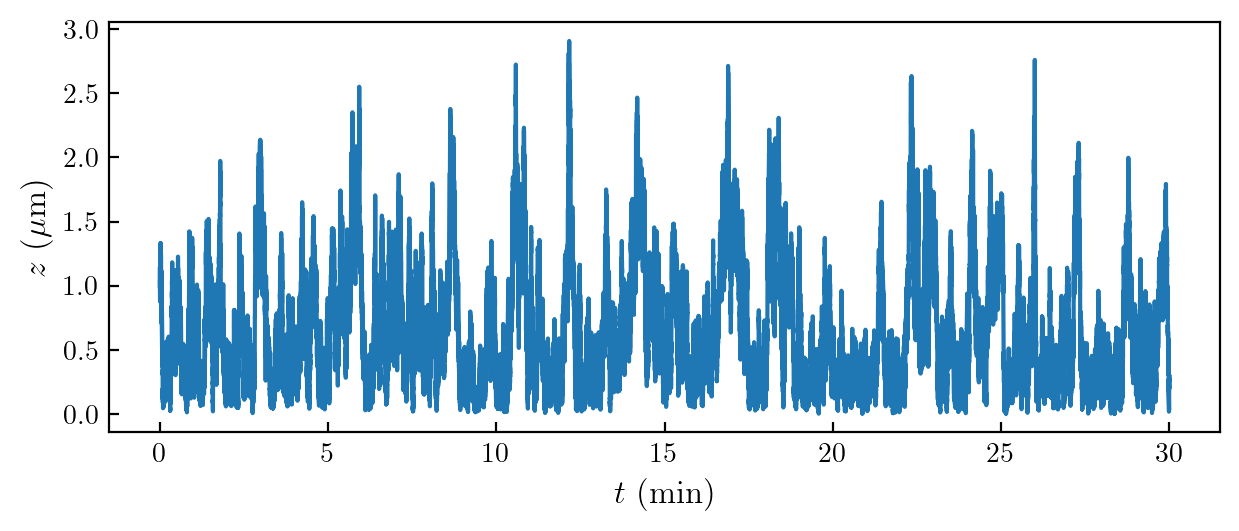

In [5]:
plt.figure(figsize=( cm2inch(16),cm2inch(7)))
plt.plot(np.arange(len(langevin3D_spurious.z[:180000]))/100 /60 , langevin3D_spurious.z[:180000]*1e6)
plt.ylabel("$z$ ($\mu$m)")
plt.xlabel("$t$ (min)")
plt.tight_layout()

plt.savefig("z_traj_sim.pdf")

In [6]:
def pdf(data, bins = 10, density = True):
    
    pdf, bins_edge = np.histogram(data, bins = bins, density = density)
    bins_center = (bins_edge[0:-1] + bins_edge[1:]) / 2
    
    return pdf, bins_center

In [7]:
ld = 50e-9
B = 4
lb = 4e-21 / (4/3 * np.pi * 1.5e-6 ** 3 * 50 * 9.81)
def _Peq(z):
    if z <= 0:
        return 0
    else:
        return np.exp(-(B * np.exp(-z / ld) + z / lb))
def Peq(z):
    P = np.array([_Peq(zi) for zi in z])
    return P / np.trapz(P,z)

In [8]:
pdf_spurious, z_spurious = pdf(langevin3D_spurious.z[langevin3D_spurious.z < 1.5e-6], bins = 100)
pdf_no_spurious, z_no_spurious = pdf(langevin3D_no_spurious.z[langevin3D_no_spurious.z < 1.5e-6], bins = 100)

In [9]:
z = np.linspace(10e-9, 2e-6, 1000)

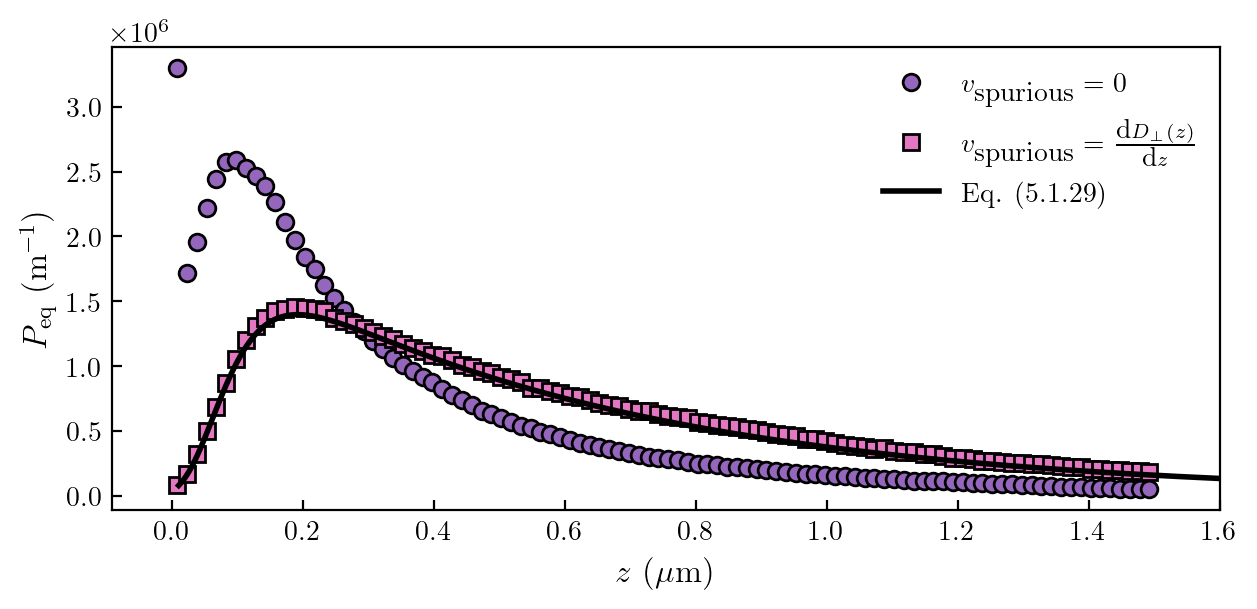

In [16]:
plt.figure(figsize=( cm2inch(16),cm2inch(8)))

plt.plot(z_no_spurious*1e6,pdf_no_spurious, "o", label = "$v_\\textnormal{spurious} = 0$", color="tab:purple")
plt.plot(z_spurious*1e6,pdf_spurious, "s", label = "$v_\\textnormal{spurious} = \\frac{\\textnormal{d}D_\\bot(z)}{\\textnormal{d}z}$", color="tab:pink")
plt.plot(z*1e6, Peq(z), color="black", label="Eq. (5.1.29)", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("$z$ ($\mu$m)")
plt.ylabel("$P_\mathrm{eq}$ (m$^{-1}$)")

plt.tight_layout()
plt.xlim([None, 1.6])
plt.savefig("Peq_vs_alpha.pdf")

In [11]:
lb

5.768442834908427e-07